In [22]:
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, accuracy_score, precision_score, 
    recall_score
)

In [23]:
# ==================== DEVICE SETUP ====================
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_per_process_memory_fraction(0.8, 0)
    total_mem = torch.cuda.get_device_properties(0).total_memory
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory limited to {0.8 * total_mem / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU memory limited to 5.15 GB


In [24]:
# ==================== DATA PATHS ====================
train_dir = "./train"
val_dir = "./val"
test_dir = "./test"

In [25]:
# ==================== DATA AUGMENTATION ====================
# DenseNet121 specific transforms - optimized for dense connections
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),  # Reduced from 30 for DenseNet stability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [26]:
# ==================== DATASETS ====================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

batch_size = 32  # Good for DenseNet121
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=4, pin_memory=True if torch.cuda.is_available() else False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"\nClasses ({num_classes}):", class_names)
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train: 10648 | Val: 1327 | Test: 1337


In [27]:
# ==================== CLASS WEIGHTS ====================
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("\nClass distribution:", dict(zip(class_names, counts)))
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights.cpu().numpy())


Class distribution: {'Actinic keratoses': 693, 'Chickenpox': 900, 'Cowpox': 792, 'Dermatofibroma': 191, 'HFMD': 1932, 'Healthy': 1368, 'Measles': 660, 'Monkeypox': 3408, 'Squamous cell carcinoma': 502, 'Vascular lesions': 202}
Class weights: [15.365079  11.831111  13.444445  55.74869    5.5113873  7.7836256
 16.133333   3.1244133 21.211155  52.71287  ]


In [28]:
# ==================== DENSENET121 MODEL ====================
def create_densenet121(num_classes, pretrained=True):
    """
    Create DenseNet121 model optimized for transfer learning
    """
    model = models.densenet121(pretrained=pretrained)
    
    # Get number of input features for classifier
    num_ftrs = model.classifier.in_features
    
    # Replace classifier with custom head
    # Add dropout for regularization
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, num_classes)
    )
    
    return model

model = create_densenet121(num_classes, pretrained=True)
model = model.to(device)

print(f"\nModel Architecture:")
print(f"Backbone: DenseNet121 (pretrained on ImageNet)")
print(f"Classifier input features: {model.classifier[1].in_features}")
print(f"Output classes: {num_classes}")


Model Architecture:
Backbone: DenseNet121 (pretrained on ImageNet)
Classifier input features: 1024
Output classes: 10


In [29]:
# ==================== OPTIMIZER & SCHEDULER ====================
# Different learning rates for backbone and classifier (discriminative learning)
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Lower LR for pretrained layers
    {'params': model.classifier.parameters(), 'lr': 1e-4}  # Higher LR for new classifier
], weight_decay=1e-4)

# ReduceLROnPlateau - reduces LR when validation F1 plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-7
)

num_epochs = 20  # Increased for better convergence

In [30]:
# ==================== LOSS FUNCTION ====================
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [31]:
# ==================== TRAINING FUNCTION ====================
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    """
    Train DenseNet121 with comprehensive tracking
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_f1": [], "val_precision": [], "val_recall": [],
        "learning_rates_backbone": [],
        "learning_rates_classifier": []
    }
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Track learning rates
        lr_backbone = optimizer.param_groups[0]['lr']
        lr_classifier = optimizer.param_groups[1]['lr']
        history["learning_rates_backbone"].append(lr_backbone)
        history["learning_rates_classifier"].append(lr_classifier)
        print(f"LR - Backbone: {lr_backbone:.7f} | Classifier: {lr_classifier:.7f}")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []
            
            for inputs, labels in tqdm(loader, desc=f"{phase.capitalize():5}", ncols=80):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            epoch_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            epoch_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            
            print(f"\n{phase.upper():5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"F1: {epoch_f1:.4f} | Prec: {epoch_precision:.4f} | Rec: {epoch_recall:.4f}")
            
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                history["val_precision"].append(epoch_precision)
                history["val_recall"].append(epoch_recall)
                
                # Step scheduler
                if scheduler is not None:
                    scheduler.step(epoch_f1)
                
                # Save best model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_f1': best_f1,
                        'class_names': class_names
                    }, f"{model_name}_best.pth")
                    print(f"✓ New best model saved! F1: {best_f1:.4f}")
    
    time_elapsed = time.time() - since
    print(f"\n{'='*60}")
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation F1: {best_f1:.4f}")
    print(f"{'='*60}")
    
    model.load_state_dict(best_model_wts)
    return model, history

In [32]:
# ==================== VISUALIZATION FUNCTIONS ====================
def plot_training_history(history, model_name="model"):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history["train_loss"], 'b-o', label="Train Loss", linewidth=2, markersize=5)
    axes[0, 0].plot(epochs, history["val_loss"], 'r-s', label="Val Loss", linewidth=2, markersize=5)
    axes[0, 0].set_xlabel("Epoch", fontsize=12)
    axes[0, 0].set_ylabel("Loss", fontsize=12)
    axes[0, 0].set_title("Loss Curve", fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history["train_acc"], 'b-o', label="Train Acc", linewidth=2, markersize=5)
    axes[0, 1].plot(epochs, history["val_acc"], 'r-s', label="Val Acc", linewidth=2, markersize=5)
    axes[0, 1].set_xlabel("Epoch", fontsize=12)
    axes[0, 1].set_ylabel("Accuracy", fontsize=12)
    axes[0, 1].set_title("Accuracy Curve", fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(epochs, history["val_f1"], 'g-^', label="Val F1", linewidth=2, markersize=5)
    axes[0, 2].set_xlabel("Epoch", fontsize=12)
    axes[0, 2].set_ylabel("F1 Score", fontsize=12)
    axes[0, 2].set_title("F1 Score Curve", fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(epochs, history["val_precision"], 'm-d', label="Val Precision", linewidth=2, markersize=5)
    axes[1, 0].set_xlabel("Epoch", fontsize=12)
    axes[1, 0].set_ylabel("Precision", fontsize=12)
    axes[1, 0].set_title("Precision Curve", fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(epochs, history["val_recall"], 'c-p', label="Val Recall", linewidth=2, markersize=5)
    axes[1, 1].set_xlabel("Epoch", fontsize=12)
    axes[1, 1].set_ylabel("Recall", fontsize=12)
    axes[1, 1].set_title("Recall Curve", fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 2].plot(epochs, history["learning_rates_backbone"], 'b-*', 
                   label='Backbone LR', linewidth=2, markersize=8)
    axes[1, 2].plot(epochs, history["learning_rates_classifier"], 'r-*', 
                   label='Classifier LR', linewidth=2, markersize=8)
    axes[1, 2].set_xlabel("Epoch", fontsize=12)
    axes[1, 2].set_ylabel("Learning Rate", fontsize=12)
    axes[1, 2].set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Training history saved: {model_name}_training_history.png")

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    """Plot confusion matrix with percentages"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations combining counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, square=True,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax, linewidths=0.5)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    filename = f'{title.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Confusion matrix saved: {filename}")

def plot_class_performance(y_true, y_pred, class_names):
    """Plot per-class performance metrics"""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
    
    # Precision
    axes[0].barh(df['Class'], df['Precision'], color='skyblue', edgecolor='navy')
    axes[0].set_xlabel('Precision', fontsize=12)
    axes[0].set_title('Precision by Class', fontsize=14, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['Precision']):
        axes[0].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Recall
    axes[1].barh(df['Class'], df['Recall'], color='lightcoral', edgecolor='darkred')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_title('Recall by Class', fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['Recall']):
        axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    # F1-Score
    axes[2].barh(df['Class'], df['F1-Score'], color='lightgreen', edgecolor='darkgreen')
    axes[2].set_xlabel('F1-Score', fontsize=12)
    axes[2].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    axes[2].set_xlim(0, 1)
    axes[2].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['F1-Score']):
        axes[2].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Class performance saved: class_performance.png")
    
    return df

In [33]:
# ==================== EVALUATION FUNCTION ====================
def evaluate_model(model, dataloader, dataset_name="Test"):
    """Comprehensive model evaluation"""
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating on {dataset_name} Set")
    print(f"{'='*60}")
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}", ncols=80):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{dataset_name} Set Results:")
    print(f"{'='*60}")
    print(f"Accuracy:            {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1 Score (Macro):    {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Macro):   {precision:.4f}")
    print(f"Recall (Macro):      {recall:.4f}")
    print(f"{'='*60}\n")
    
    # Classification Report
    print(f"Detailed Classification Report ({dataset_name} Set):")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, title=f'{dataset_name}_Confusion_Matrix')
    
    # Per-class performance
    df_performance = plot_class_performance(y_true, y_pred, class_names)
    print(f"\nPer-Class Performance ({dataset_name} Set):")
    print("="*70)
    print(df_performance.to_string(index=False))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': np.array(y_scores),
        'confusion_matrix': cm,
        'performance_df': df_performance
    }

In [34]:
# ==================== TRAIN MODEL ====================
print("\n" + "="*60)
print("Starting DenseNet121 Training")
print("="*60)

model, history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs, 
    model_name="DenseNet121_SkinDisease"
)


Starting DenseNet121 Training

Epoch 1/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:10<00:00,  2.55it/s]



TRAIN | Loss: 1.7477 | Acc: 0.3998 | F1: 0.3539 | Prec: 0.3446 | Rec: 0.3963


Val  : 100%|████████████████████████████████████| 42/42 [00:09<00:00,  4.26it/s]



VAL   | Loss: 1.1669 | Acc: 0.6353 | F1: 0.5864 | Prec: 0.5931 | Rec: 0.5937
✓ New best model saved! F1: 0.5864

Epoch 2/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.58it/s]



TRAIN | Loss: 1.0514 | Acc: 0.6165 | F1: 0.5867 | Prec: 0.5678 | Rec: 0.6307


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.12it/s]



VAL   | Loss: 0.8188 | Acc: 0.7084 | F1: 0.6714 | Prec: 0.6764 | Rec: 0.6924
✓ New best model saved! F1: 0.6714

Epoch 3/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.8251 | Acc: 0.6838 | F1: 0.6598 | Prec: 0.6381 | Rec: 0.7022


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.08it/s]



VAL   | Loss: 0.6438 | Acc: 0.7573 | F1: 0.7275 | Prec: 0.7177 | Rec: 0.7467
✓ New best model saved! F1: 0.7275

Epoch 4/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.6990 | Acc: 0.7297 | F1: 0.7034 | Prec: 0.6798 | Rec: 0.7450


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.80it/s]



VAL   | Loss: 0.5589 | Acc: 0.7943 | F1: 0.7792 | Prec: 0.7753 | Rec: 0.8087
✓ New best model saved! F1: 0.7792

Epoch 5/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.57it/s]



TRAIN | Loss: 0.5981 | Acc: 0.7626 | F1: 0.7414 | Prec: 0.7184 | Rec: 0.7801


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.70it/s]



VAL   | Loss: 0.4896 | Acc: 0.8018 | F1: 0.7878 | Prec: 0.7711 | Rec: 0.8204
✓ New best model saved! F1: 0.7878

Epoch 6/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.57it/s]



TRAIN | Loss: 0.5376 | Acc: 0.7844 | F1: 0.7622 | Prec: 0.7402 | Rec: 0.7975


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.01it/s]



VAL   | Loss: 0.4210 | Acc: 0.8357 | F1: 0.8196 | Prec: 0.8115 | Rec: 0.8471
✓ New best model saved! F1: 0.8196

Epoch 7/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.4747 | Acc: 0.8125 | F1: 0.7911 | Prec: 0.7688 | Rec: 0.8257


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.89it/s]



VAL   | Loss: 0.3975 | Acc: 0.8493 | F1: 0.8237 | Prec: 0.8046 | Rec: 0.8625
✓ New best model saved! F1: 0.8237

Epoch 8/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.4337 | Acc: 0.8276 | F1: 0.8101 | Prec: 0.7888 | Rec: 0.8424


Val  : 100%|████████████████████████████████████| 42/42 [00:09<00:00,  4.60it/s]



VAL   | Loss: 0.3591 | Acc: 0.8606 | F1: 0.8280 | Prec: 0.8195 | Rec: 0.8599
✓ New best model saved! F1: 0.8280

Epoch 9/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.3947 | Acc: 0.8483 | F1: 0.8344 | Prec: 0.8144 | Rec: 0.8621


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.79it/s]



VAL   | Loss: 0.3210 | Acc: 0.8794 | F1: 0.8697 | Prec: 0.8499 | Rec: 0.9009
✓ New best model saved! F1: 0.8697

Epoch 10/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.3572 | Acc: 0.8578 | F1: 0.8407 | Prec: 0.8210 | Rec: 0.8681


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.70it/s]



VAL   | Loss: 0.2963 | Acc: 0.8839 | F1: 0.8699 | Prec: 0.8579 | Rec: 0.8928
✓ New best model saved! F1: 0.8699

Epoch 11/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.58it/s]



TRAIN | Loss: 0.3268 | Acc: 0.8684 | F1: 0.8526 | Prec: 0.8339 | Rec: 0.8779


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.81it/s]



VAL   | Loss: 0.2899 | Acc: 0.8870 | F1: 0.8705 | Prec: 0.8629 | Rec: 0.8954
✓ New best model saved! F1: 0.8705

Epoch 12/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.3018 | Acc: 0.8797 | F1: 0.8651 | Prec: 0.8479 | Rec: 0.8880


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.02it/s]



VAL   | Loss: 0.2665 | Acc: 0.8907 | F1: 0.8757 | Prec: 0.8711 | Rec: 0.8975
✓ New best model saved! F1: 0.8757

Epoch 13/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.2913 | Acc: 0.8853 | F1: 0.8713 | Prec: 0.8546 | Rec: 0.8925


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.79it/s]



VAL   | Loss: 0.2613 | Acc: 0.9103 | F1: 0.8885 | Prec: 0.8754 | Rec: 0.9121
✓ New best model saved! F1: 0.8885

Epoch 14/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.2747 | Acc: 0.8903 | F1: 0.8726 | Prec: 0.8554 | Rec: 0.8947


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.72it/s]



VAL   | Loss: 0.2348 | Acc: 0.9088 | F1: 0.8944 | Prec: 0.8865 | Rec: 0.9103
✓ New best model saved! F1: 0.8944

Epoch 15/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.2517 | Acc: 0.9020 | F1: 0.8889 | Prec: 0.8731 | Rec: 0.9092


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.67it/s]



VAL   | Loss: 0.2187 | Acc: 0.9179 | F1: 0.8931 | Prec: 0.8748 | Rec: 0.9190

Epoch 16/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.57it/s]



TRAIN | Loss: 0.2273 | Acc: 0.9113 | F1: 0.9044 | Prec: 0.8907 | Rec: 0.9207


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.06it/s]



VAL   | Loss: 0.1992 | Acc: 0.9261 | F1: 0.9054 | Prec: 0.8943 | Rec: 0.9218
✓ New best model saved! F1: 0.9054

Epoch 17/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.58it/s]



TRAIN | Loss: 0.2292 | Acc: 0.9095 | F1: 0.8967 | Prec: 0.8836 | Rec: 0.9130


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.09it/s]



VAL   | Loss: 0.1857 | Acc: 0.9292 | F1: 0.9038 | Prec: 0.8936 | Rec: 0.9215

Epoch 18/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:08<00:00,  2.59it/s]



TRAIN | Loss: 0.2261 | Acc: 0.9195 | F1: 0.9007 | Prec: 0.8887 | Rec: 0.9151


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.83it/s]



VAL   | Loss: 0.1782 | Acc: 0.9405 | F1: 0.9286 | Prec: 0.9225 | Rec: 0.9375
✓ New best model saved! F1: 0.9286

Epoch 19/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.2014 | Acc: 0.9225 | F1: 0.9111 | Prec: 0.8988 | Rec: 0.9258


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  4.85it/s]



VAL   | Loss: 0.1863 | Acc: 0.9292 | F1: 0.9021 | Prec: 0.8975 | Rec: 0.9168

Epoch 20/20
LR - Backbone: 0.0000100 | Classifier: 0.0001000


Train: 100%|██████████████████████████████████| 333/333 [02:09<00:00,  2.58it/s]



TRAIN | Loss: 0.1881 | Acc: 0.9287 | F1: 0.9176 | Prec: 0.9056 | Rec: 0.9317


Val  : 100%|████████████████████████████████████| 42/42 [00:08<00:00,  5.01it/s]


VAL   | Loss: 0.1763 | Acc: 0.9322 | F1: 0.9122 | Prec: 0.9047 | Rec: 0.9241

Training complete in 45m 59s
Best Validation F1: 0.9286


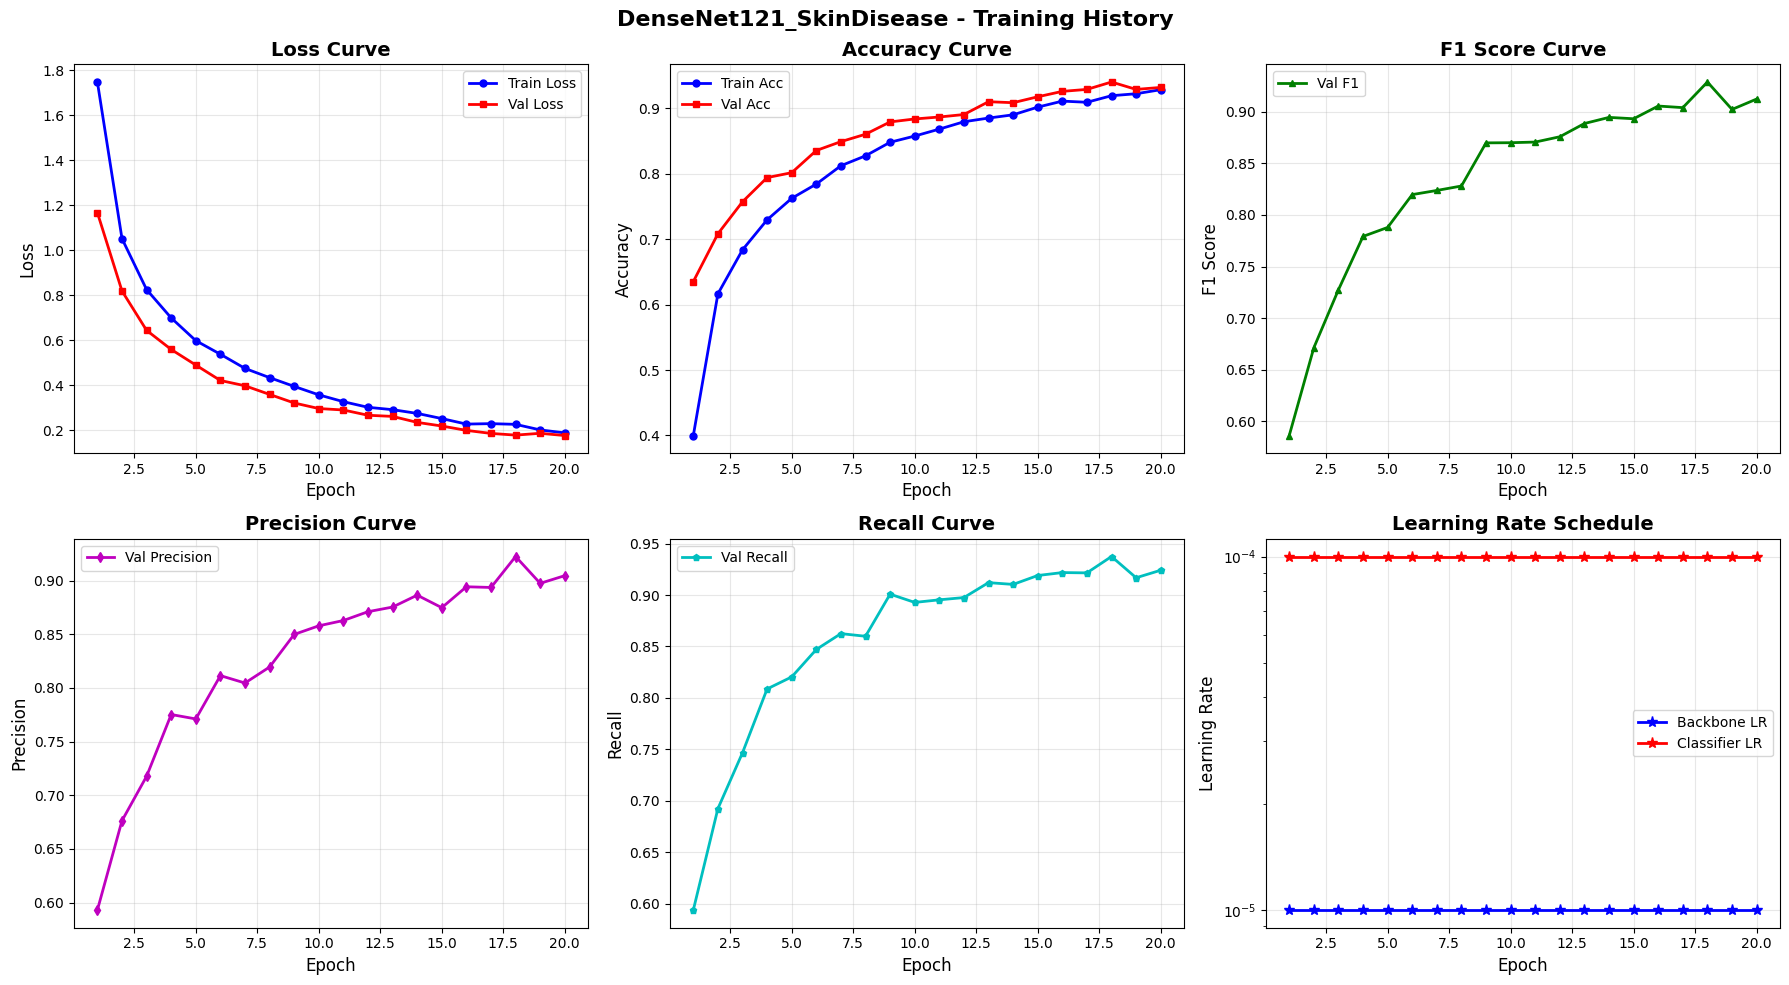

✓ Training history saved: DenseNet121_SkinDisease_training_history.png

Evaluating on Validation Set


Evaluating Validation: 100%|████████████████████| 42/42 [00:08<00:00,  5.00it/s]



Validation Set Results:
Accuracy:            0.9405 (94.05%)
F1 Score (Macro):    0.9286
F1 Score (Weighted): 0.9407
Precision (Macro):   0.9225
Recall (Macro):      0.9375

Detailed Classification Report (Validation Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.8831    0.7907    0.8344        86
             Chickenpox     0.8871    0.9821    0.9322       112
                 Cowpox     0.9697    0.9697    0.9697        99
         Dermatofibroma     0.9130    0.9130    0.9130        23
                   HFMD     0.9790    0.9668    0.9729       241
                Healthy     0.8906    1.0000    0.9421       171
                Measles     0.9518    0.9634    0.9576        82
              Monkeypox     0.9899    0.9178    0.9525       426
Squamous cell carcinoma     0.7606    0.8710    0.8120        62
       Vascular lesions     1.0000    1.0000    1.0000        25

               accuracy                         0.9405     

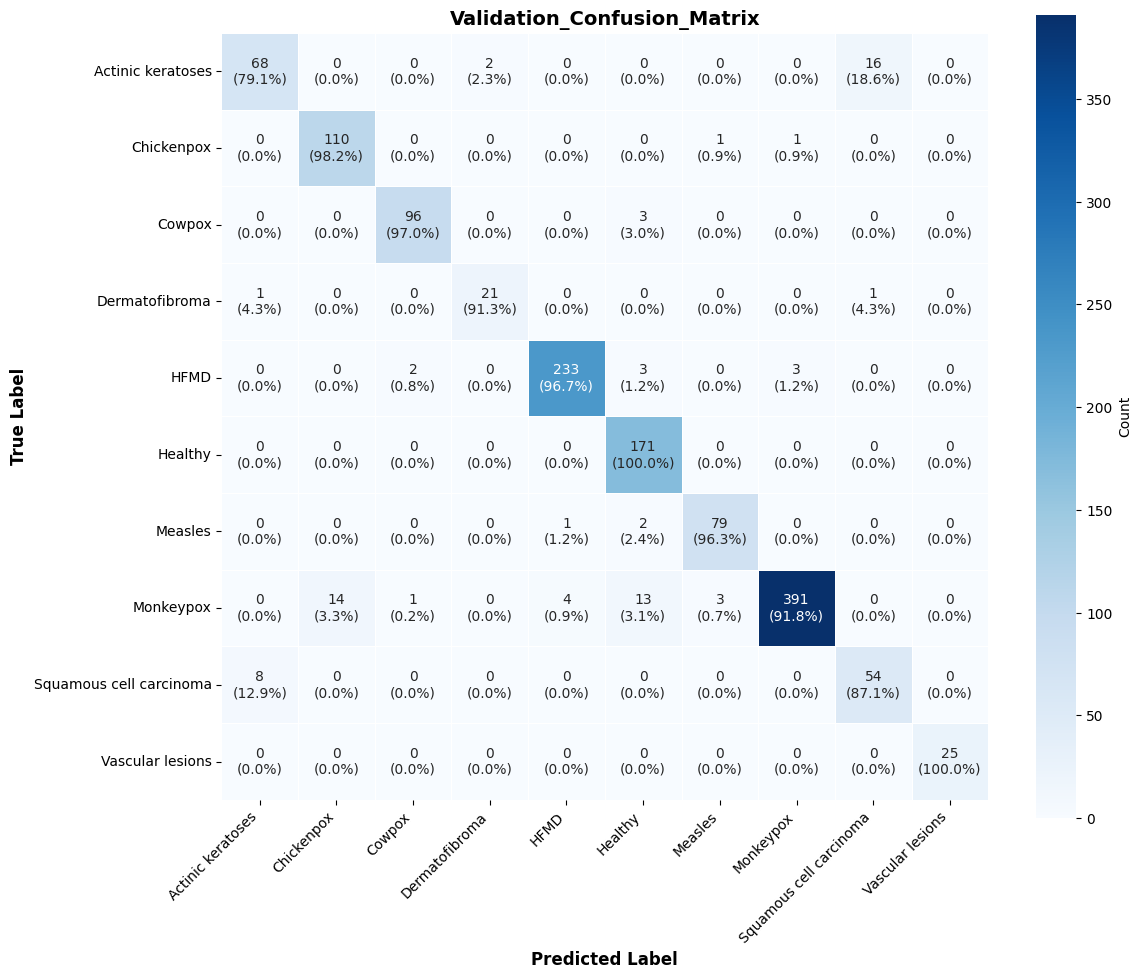

✓ Confusion matrix saved: Validation_Confusion_Matrix.png


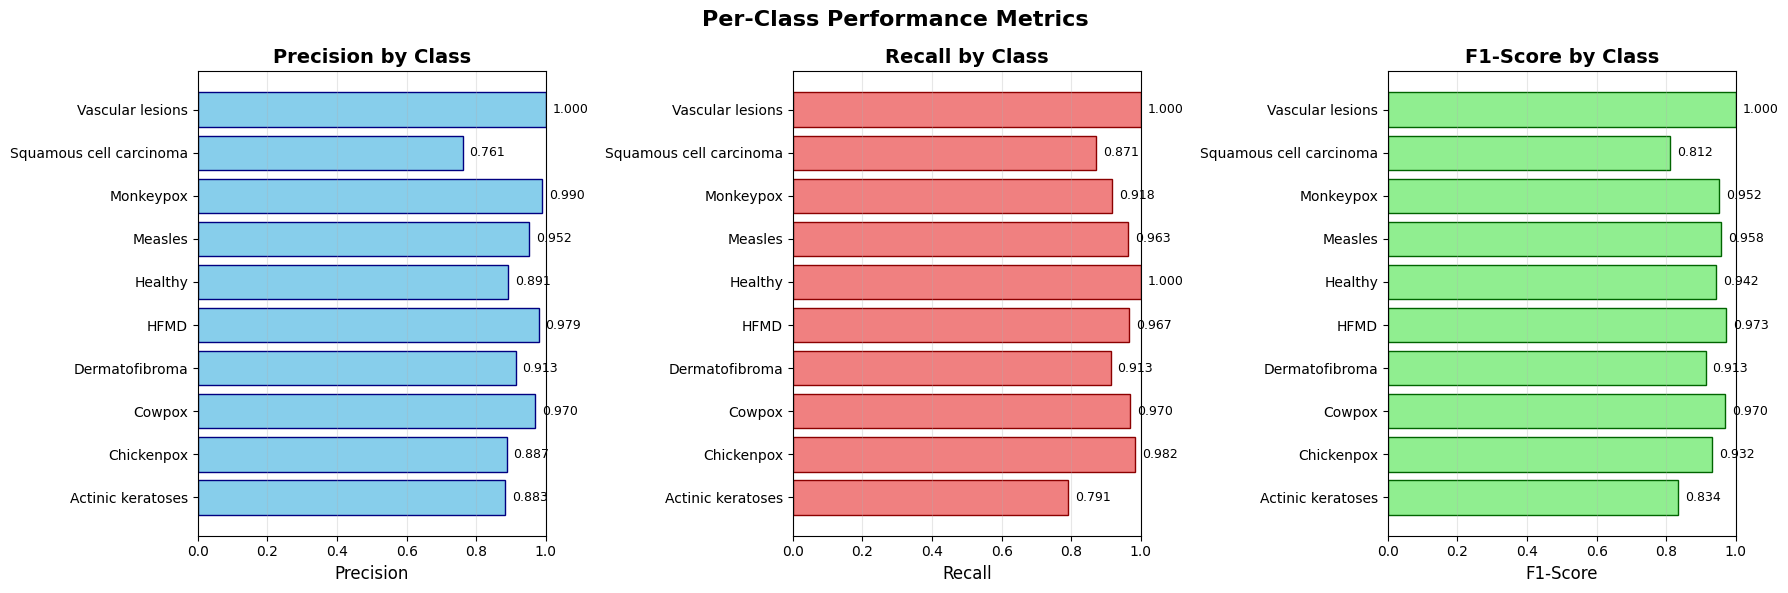

✓ Class performance saved: class_performance.png

Per-Class Performance (Validation Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.883117 0.790698  0.834356       86
             Chickenpox   0.887097 0.982143  0.932203      112
                 Cowpox   0.969697 0.969697  0.969697       99
         Dermatofibroma   0.913043 0.913043  0.913043       23
                   HFMD   0.978992 0.966805  0.972860      241
                Healthy   0.890625 1.000000  0.942149      171
                Measles   0.951807 0.963415  0.957576       82
              Monkeypox   0.989873 0.917840  0.952497      426
Squamous cell carcinoma   0.760563 0.870968  0.812030       62
       Vascular lesions   1.000000 1.000000  1.000000       25

Evaluating on Test Set


Evaluating Test: 100%|██████████████████████████| 42/42 [00:09<00:00,  4.35it/s]



Test Set Results:
Accuracy:            0.9260 (92.60%)
F1 Score (Macro):    0.9134
F1 Score (Weighted): 0.9264
Precision (Macro):   0.9070
Recall (Macro):      0.9245

Detailed Classification Report (Test Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.8816    0.7614    0.8171        88
             Chickenpox     0.8333    0.9735    0.8980       113
                 Cowpox     0.9065    0.9798    0.9417        99
         Dermatofibroma     0.9565    0.8800    0.9167        25
                   HFMD     0.9870    0.9380    0.9619       242
                Healthy     0.9091    0.9942    0.9497       171
                Measles     0.9286    0.9398    0.9341        83
              Monkeypox     0.9772    0.9038    0.9390       426
Squamous cell carcinoma     0.7273    0.8750    0.7943        64
       Vascular lesions     0.9630    1.0000    0.9811        26

               accuracy                         0.9260      1337
      

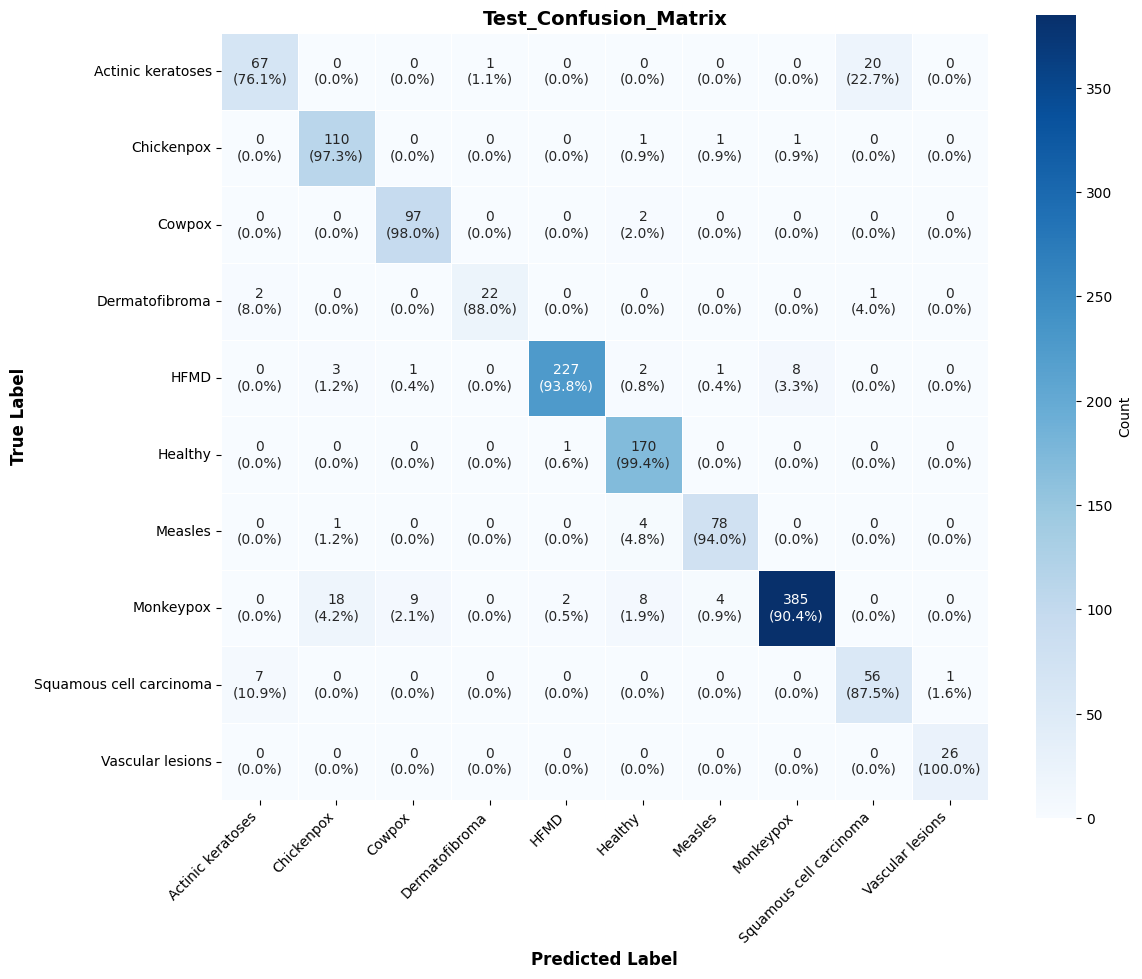

✓ Confusion matrix saved: Test_Confusion_Matrix.png


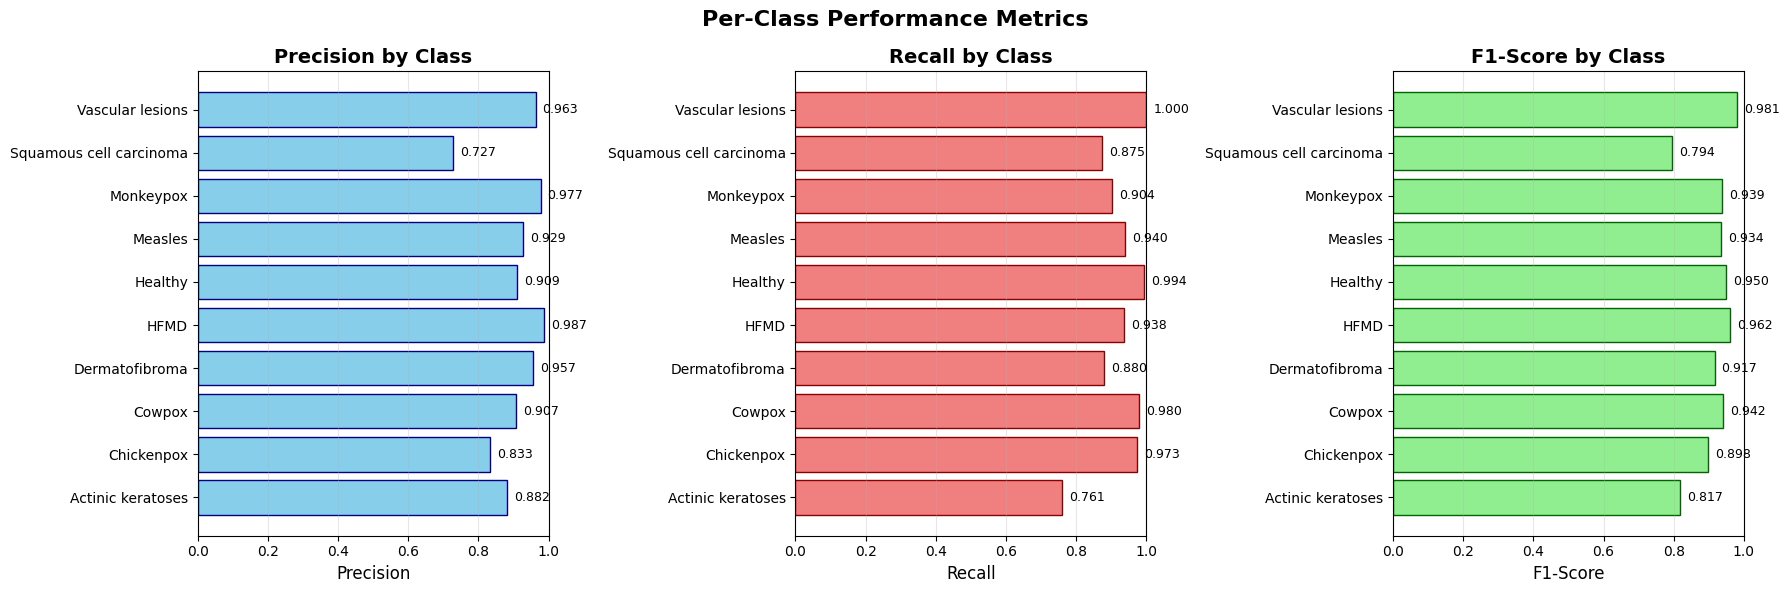

✓ Class performance saved: class_performance.png

Per-Class Performance (Test Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.881579 0.761364  0.817073       88
             Chickenpox   0.833333 0.973451  0.897959      113
                 Cowpox   0.906542 0.979798  0.941748       99
         Dermatofibroma   0.956522 0.880000  0.916667       25
                   HFMD   0.986957 0.938017  0.961864      242
                Healthy   0.909091 0.994152  0.949721      171
                Measles   0.928571 0.939759  0.934132       83
              Monkeypox   0.977157 0.903756  0.939024      426
Squamous cell carcinoma   0.727273 0.875000  0.794326       64
       Vascular lesions   0.962963 1.000000  0.981132       26


In [35]:
# ==================== PLOT TRAINING HISTORY ====================
plot_training_history(history, model_name="DenseNet121_SkinDisease")

# ==================== EVALUATE ON VALIDATION SET ====================
val_results = evaluate_model(model, val_loader, dataset_name="Validation")

# ==================== EVALUATE ON TEST SET ====================
test_results = evaluate_model(model, test_loader, dataset_name="Test")

In [39]:
# ==================== SAVE FINAL RESULTS ====================
results_summary = {
    'Model': 'DenseNet121',
    'Train_Loss_Final': history['train_loss'][-1],
    'Val_Loss_Final': history['val_loss'][-1],
    'Train_Loss_Best': min(history['train_loss']),
    'Val_Loss_Best': min(history['val_loss']),
    'Validation_Accuracy': val_results['accuracy'],
    'Validation_F1_Macro': val_results['f1_macro'],
    'Test_Accuracy': test_results['accuracy'],
    'Test_F1_Macro': test_results['f1_macro'],
    'Test_Precision': test_results['precision'],
    'Test_Recall': test_results['recall']
}

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key:.<40} {value:.4f}")
    else:
        print(f"{key:.<40} {value}")
print("="*60)

# ==================== DISPLAY LOSS HISTORY ====================
print("\n" + "="*60)
print("LOSS HISTORY (All Epochs)")
print("="*60)
print(f"{'Epoch':<8} {'Train Loss':<15} {'Val Loss':<15}")
print("-" * 60)
for epoch, (train_loss, val_loss) in enumerate(zip(history['train_loss'], history['val_loss']), 1):
    print(f"{epoch:<8} {train_loss:<15.4f} {val_loss:<15.4f}")
print("="*60)


FINAL RESULTS SUMMARY
Model................................... DenseNet121
Train_Loss_Final........................ 0.1881
Val_Loss_Final.......................... 0.1763
Train_Loss_Best......................... 0.1881
Val_Loss_Best........................... 0.1763
Validation_Accuracy..................... 0.9405
Validation_F1_Macro..................... 0.9286
Test_Accuracy........................... 0.9260
Test_F1_Macro........................... 0.9134
Test_Precision.......................... 0.9070
Test_Recall............................. 0.9245

LOSS HISTORY (All Epochs)
Epoch    Train Loss      Val Loss       
------------------------------------------------------------
1        1.7477          1.1669         
2        1.0514          0.8188         
3        0.8251          0.6438         
4        0.6990          0.5589         
5        0.5981          0.4896         
6        0.5376          0.4210         
7        0.4747          0.3975         
8        0.4337          0.3

In [38]:
# ==================== SAVE FINAL MODEL ====================
# Save the final trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'history': history,
    'val_results': val_results,
    'test_results': test_results
}, "DenseNet121_SkinDisease_final.pth")

print(f"✓ Final model saved as: DenseNet121_SkinDisease_final.pth")

# Save model architecture + weights (can be loaded directly)
torch.save(model, "DenseNet121_SkinDisease_complete.pth")
print(f"✓ Complete model saved as: DenseNet121_SkinDisease_complete.pth")

print("\n" + "="*60)
print("SAVED FILES:")
print("="*60)
print("1. DenseNet121_SkinDisease_best.pth      - Best model during training")
print("2. DenseNet121_SkinDisease_final.pth     - Final model with full training info")
print("3. DenseNet121_SkinDisease_complete.pth  - Complete model (architecture + weights)")
print("="*60)

✓ Final model saved as: DenseNet121_SkinDisease_final.pth
✓ Complete model saved as: DenseNet121_SkinDisease_complete.pth

SAVED FILES:
1. DenseNet121_SkinDisease_best.pth      - Best model during training
2. DenseNet121_SkinDisease_final.pth     - Final model with full training info
3. DenseNet121_SkinDisease_complete.pth  - Complete model (architecture + weights)
